## Avaliação em holdouts - Amazon Digital Music

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
# Amazon Digital Music
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [4]:
data = pd.read_csv('output/amazon_digmusic_dump/sampled_amazon_digmusic.csv')
dataset_name = 'Amazon_digital_music'
user_col = 'user_id'
item_col = 'item_id'

In [5]:
data.shape, data.user_id.nunique(), data.item_id.nunique()

((95224, 4), 19850, 63598)

In [6]:
data[['user_id', 'item_id']].duplicated().sum()

8886

In [7]:
data.head()

,user_id,item_id,timestamp,date
0,0006935257,A1KOXZZ2FAVWE0,1388534400,2014-01-01
1,1932192077,A2YIH1J1C1IAN,1388534400,2014-01-01
2,5557585400,A3LEJBI2BBW9S1,1388534400,2014-01-01
3,5558433892,AQCR49SH6TGL4,1388534400,2014-01-01
4,B000031WES,ASRAMMXBYFR6T,1388534400,2014-01-01


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95224 entries, 0 to 95223
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    95224 non-null  object
 1   item_id    95224 non-null  object
 2   timestamp  95224 non-null  int64 
 3   date       95224 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


### Convert timestamp

In [9]:
%%time 
# 2.42s
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
# data.sort_values(by='timestamp', inplace=True)

CPU times: total: 594 ms
Wall time: 928 ms


In [10]:
data.head()

,user_id,item_id,timestamp,date
0,0006935257,A1KOXZZ2FAVWE0,1388534400,2014-01-01
1,1932192077,A2YIH1J1C1IAN,1388534400,2014-01-01
2,5557585400,A3LEJBI2BBW9S1,1388534400,2014-01-01
3,5558433892,AQCR49SH6TGL4,1388534400,2014-01-01
4,B000031WES,ASRAMMXBYFR6T,1388534400,2014-01-01


CPU times: total: 15.6 ms
Wall time: 102 ms


Text(0.5, 1.0, 'interactions per month')

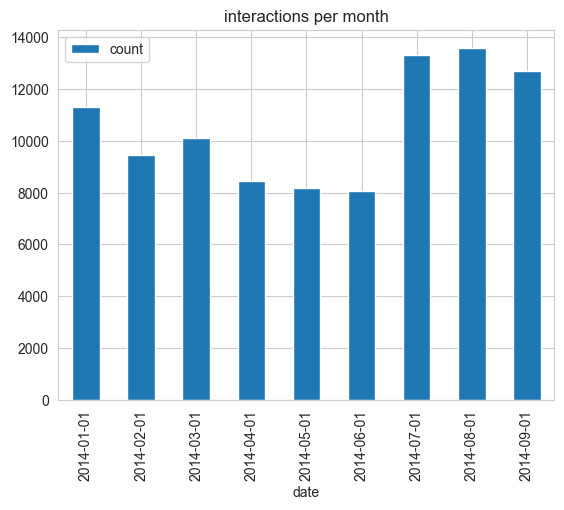

In [11]:
%%time
# 198ms
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.date
_.groupby('date').sum().plot(kind='bar')
plt.title('interactions per month');

___
## Get intervals and Frequent users (threshold = 0.75)

time intervals

In [12]:
user_presence_df = pd.read_csv('output/amazon_digmusic_dump/sample_user_presence_df.csv')
user_month_interactions = pd.read_csv('output/amazon_digmusic_dump/sample_user_month_interactions.csv')

___
## Experiments using Quarter/Semester

In [13]:
data.shape

(95224, 4)

In [17]:
trimestres = joblib.load('output/amazon_digmusic_dump/sample_trimestres.joblib')
semestres = joblib.load('output/amazon_digmusic_dump/sample_semestres.joblib')
frequent_users = joblib.load('output/amazon_digmusic_dump/sample_frequent_users.joblib')

In [22]:
%%time
# 3min 38s
buckets, holdouts = getBucketsHoldouts(
    data=data,# data[ data['date'].dt.month==1 ],#
    user_col=user_col,
    item_col=item_col,
    frequent_users=frequent_users[1],#data['user_id'].unique(),
    interval_type='QS',
    intervals=trimestres, 
    cold_start_buckets=0)

Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 652
common interactions between holdout 2 and all buckets: 629
common interactions between holdout 3 and all buckets: 589
Converting to ImplicitData. . .
Done!
CPU times: total: 23 s
Wall time: 31.7 s


In [23]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

95224

In [24]:
joblib.dump(buckets, 'output/amazon_digmusic_dump/sample_buckets.joblib')
joblib.dump(holdouts, 'output/amazon_digmusic_dump/sample_holdouts.joblib')

['output/amazon_digmusic_dump/sample_holdouts.joblib']

In [25]:
buckets = joblib.load('output/amazon_digmusic_dump/sample_buckets.joblib')
holdouts = joblib.load('output/amazon_digmusic_dump/sample_holdouts.joblib')

In [27]:
[(b.size, len(b.userset), len(b.itemset)) for b in buckets]

[(29000, 10869, 20990), (21712, 8391, 16291), (36603, 12331, 24212)]

In [28]:
[(b.size, len(b.userset), len(b.itemset)) for b in holdouts]

[(1865, 1865, 1738), (3002, 3002, 2731), (3042, 3042, 2594)]

### ISGD

Hyperparameters

In [29]:
GRID_SEARCH = False

In [30]:
%%time
import itertools
def grid_search(model, stream, random_seed = 10, interleaved=10):    
    num_factors = [50, 100, 150, 200]
    num_iter = [1, 2, 5, 8]
    learn_rate = [0.01, 0.05, 0.1, 0.25, 0.5]
    regularization = [0.01, 0.05, 0.1, 0.25, 0.5]
    num_nodes = [1, 2, 4, 8, 16]
    grid = [num_factors, num_iter, learn_rate, regularization, num_nodes]
    grid = list(itertools.product(*grid))
    results = []
    for i, hp in enumerate(grid):
        print(((i*100)/len(grid)), '%')
        empty_stream = ImplicitData([], [])
        nf, ni, lr, reg, nn = hp
        m = model(empty_stream, nf, ni, lr, reg, reg, random_seed)
        e = EvalPrequential(m, stream, metrics = ["Recall@N"])
        result = e.Evaluate(start_eval=0, count=stream.size, interleaved=interleaved)
        results.append( np.mean(result['Recall@N']) )
    return grid, results    

# OPTIONAL FOR NOW
if GRID_SEARCH:
    prop = 0.05 # 0.1 #
    hp_sample = data.iloc[:round( data.shape[0]*prop )]
    stream = ImplicitData(hp_sample[user_col], hp_sample[item_col]) #(data['playlist_id'],data['track_id'])    
    grid, results = grid_search(model=ISGD, stream=stream, random_seed=10, interleaved=100 )
    len(grid), len(results), max(results) # (243, 243, 0.0026656511805026656)
    print(  grid[ np.argmax( results ) ] )

CPU times: total: 0 ns
Wall time: 0 ns


In [31]:
if GRID_SEARCH:
    num_factors, num_iter, learn_rate, regularization, num_nodes = grid[ np.argmax( results ) ]
else:
    num_factors = 100
    num_iter = 6
    learn_rate = 0.1
    regularization = 0.1
    num_nodes = None

# previous  (100, 5, 0.5, 0.3, 4)

# OLD
# define hyperparameters (SAME AS LASTFM) ????
# num_factors = 160
# num_iter = 4
# learn_rate = 0.5
# regularization = 0.4
# num_nodes = 8

In [32]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, 
             num_factors, 
             num_iter, 
             learn_rate = learn_rate,
             u_regularization = regularization,
             i_regularization = regularization,
             random_seed = 10)

In [33]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [34]:
%%time
# 1h 27min 10s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
Test Holdout 2
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
Test Holdout 2
----------------------------------------------------------------------------------------------------
Train bucket 2
Test Holdout 0
Test Holdout 1
Test Holdout 2
CPU times: total: 38min 36s
Wall time: 52min 8s


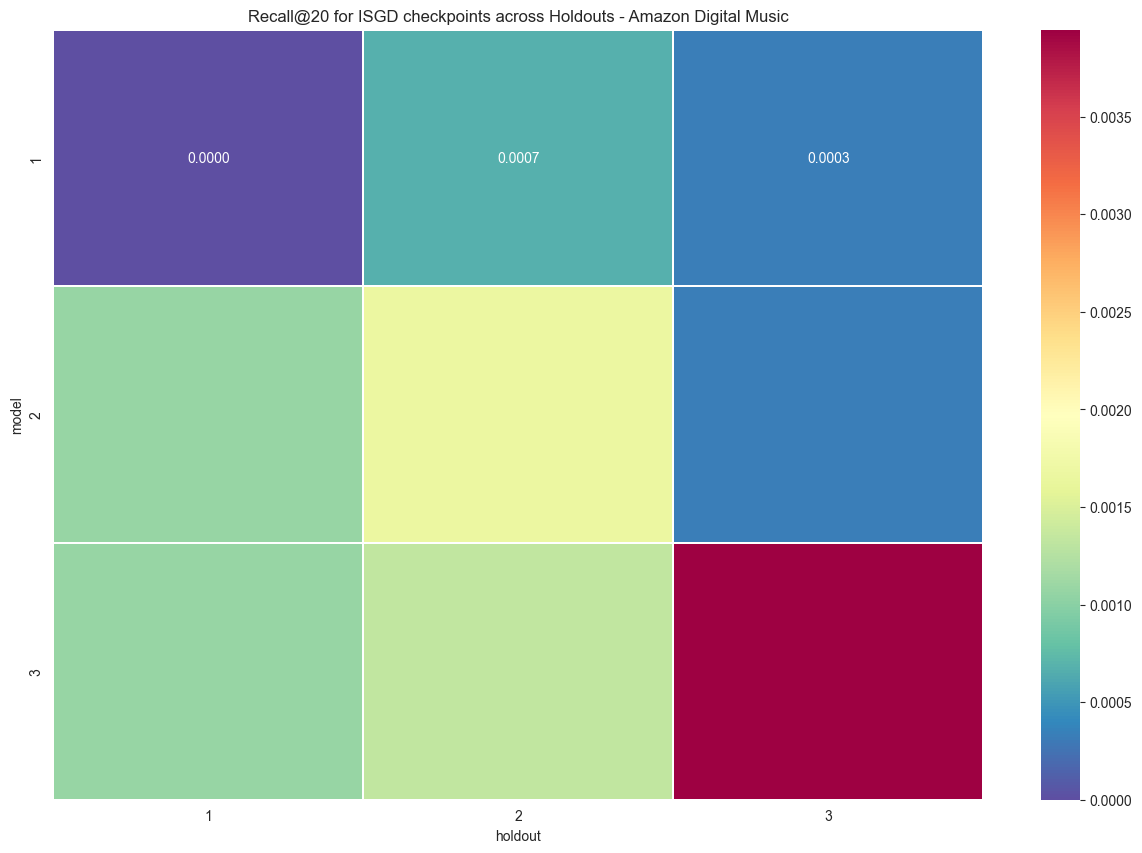

In [35]:
rm = eval.results_matrix
df = pd.DataFrame(rm)
df.to_csv('output/amazon_digmusic_dump/sample_amazon_digital_music quarterly_bucket ISGD results.csv', index=False)

recall_heatmap(df,
    round_point=4,
    title='Recall@20 for ISGD checkpoints across Holdouts - Amazon Digital Music',
    filepath='images/heatmaps/amazon_digmusic_dump/sample_amazon_digital_music quarterly_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [36]:
arecall = avg_recall(df)
arecall

0.0018701098237817349

In [37]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([0.0010723860589812334, 0.00036963739991033686], 0.0007210117294457852)

In [38]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0004412282380816179

In [39]:
joblib.dump(eval.IncrementalTraining_time_record, 'output/amazon_digmusic_dump/sample_amazon_digmusic quarterly_bucket ISGD training time.joblib')
joblib.dump(eval.EvaluateHoldouts_time_record, 'output/amazon_digmusic_dump/sample_amazon_digmusic quarterly_bucket ISGD eval time.joblib')

['output/amazon_digmusic_dump/sample_amazon_digmusic quarterly_bucket ISGD eval time.joblib']

In [40]:
import pandas as pd
import numpy as np

def avg_recall(results_matrix):
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Díaz-Rodriguez et al. 2018
    diff = []
    n_checkpoints = results_matrix.shape[0]
    for i in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        for j in range(i):
            Rij = results_matrix.iloc[i,j] # get models performances' on previous holdouts
            Rjj = results_matrix.iloc[j,j] # get models performances' on their closest holdouts (diagonal)
            # print(Rij, Rjj)
            diff.append( Rij - Rjj ) # future models performances' - performances' of models closest to holdouts (diagonal)
            # print(diff)
    BWT = sum(diff) / ( n_checkpoints*(n_checkpoints-1) / 2 ) # store average BWT for model
    return BWT, diff # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

In [41]:
df = pd.read_csv('output/amazon_digmusic_dump/sample_amazon_digital_music quarterly_bucket ISGD results.csv')

In [42]:
df

,0,1,2
0,0.000000,0.000666,0.000329
1,0.001072,0.001666,0.000329
2,0.001072,0.001332,0.003945


In [43]:
avg_recall(df).round(5)

0.00187

In [44]:
BWT, diff = compute_BWT(df)
BWT.round(6)

0.000604

In [45]:
compute_FWT(df)

0.0004412282380816179